In [84]:
# integration & subtraction methods
# time binning in next cell

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import math
import scipy.optimize
import datetime
from scipy.integrate import trapz
get_ipython().run_line_magic('matplotlib', 'inline')



def setup(filename):
    df = pd.read_csv(filename)
    df = df.fillna(method = 'ffill') # forward-filling all the NaNs
    timedata = df.loc[:, 'deviceTime_unix'] # finding time data
    timevals = df['deviceTime_unix'].to_list()
    df = df.set_index('deviceTime_unix')
    spectra = df.loc[:, '0':'1023'] 
    array = spectra.to_numpy()
    spectrum = array.sum(axis = 0)
    x_all = np.array(range(0, 1024))
    y_all = spectrum
    return x_all, y_all


# integration method

def arguments (**keywordargs): # seperating p0 and gaussian kwargs 
    p0 = keywordargs['p0']
    gauss_guess = []
 
    gauss_guess.append(keywordargs['amp'])
    gauss_guess.append(keywordargs['x0'])
    gauss_guess.append(keywordargs['sigma'])
    return  p0, gauss_guess

def gaussian(x, amp, x0, sigma):
    return amp*np.exp(-(x-x0)**2/(2*sigma**2))

def gaussian_function(x, a, b, amp, x0, sigma): 
    return (x*a + b + gaussian(x, amp, x0, sigma))
   
def NetCounts_integration(x, y, xbounds_left, xbounds_right, **kwargs):
    '''
    Returns net counts of given peak using Gaussian integration.
    
        Parameters:
            x (array): x values
            y (array): y values
            xbounds_left (int): left bound of peak
            xbounds_right (int): right bound of peak
            Keyword arguments:
            p0 (list): estimate values for exponential curve fit
            amp (int): amplitude of peak
            x0 (int): mean of distribution
            sigma (float): sigma (variance) value
            a (int), Optional: estimate value for base; defaults to 1
            b (int), Optional: estimate value for base; defaults to 1
            
        Returns:
            integrated (float): Net counts as determined by Gaussian integration
    '''
    
    r_idx = np.where(x == xbounds_right) # finding index of xbounds_right value    
    r_idx = int(r_idx[0][0])
    
    l_idx = np.where(x== xbounds_left) # finding index of xbounds_left
    l_idx = int(l_idx[0][0])
    
    xpeak = x[l_idx:r_idx] 
    ypeak = y[l_idx:r_idx] 
    
    p0, gauss_guess = arguments(**kwargs)
  
    popt, pcov = scipy.optimize.curve_fit(gaussian, xpeak, ypeak, gauss_guess)
    print(popt)

    gauss_vals = gaussian(xpeak, *popt) # gaussian fit values
    plt.figure(figsize = (10, 6)) 
    plt.plot(xpeak, ypeak, label="data")
    plt.plot(xpeak, gauss_vals, '-y', label = 'Gaussian') 
    plt.legend()
    plt.title("Gaussian Integration")
    plt.grid()
    plt.legend()
    plt.show()

    # integrating
    integrated = gauss_vals.sum()
    print('Net counts:', integrated)
    
    return integrated


params = {'p0':[1000, 0.05], 'offset':None, 'tail length':0.46}
# Note: if curve fit is underestimating drastically, try reducing tail length
#       if curve fit is overestimating drastically, try increasing tail length



# Using background subtraction 

def seperate_args (**keywordargs): # seperating p0 and gaussian kwargs 
    p0 = keywordargs['p0']
    offset = keywordargs['offset']
    if offset == None:
        offset = 0.1
    tail_length = keywordargs['tail length']
    if tail_length == None:
        tail_length = 0.25
    plot_all = keywordargs['plot_all']
    return p0, offset, tail_length, plot_all

def exponential_curve(x, m, t): 
    return m * np.exp(-t * x) 
         
def NetCounts_subtraction(x, y, xbounds_left, xbounds_right, **kwargs):
    '''
    Uses two approaches to subtract background counts and return net counts of given peak.
    
        Parameters:
            x (array): x values
            y (array): y values
            xbounds_left (int): left bound of peak
            xbounds_right (int): right bound of peak
            Keyword arguments:
            p0 (list): estimate values for exponential curve fit
            offset (float), Optional: percentage of offset to avoid noise early in data; defaults to 0.1
            tail length (float), Optional: percentage of data to use as tail; defaults to 0.25
            plot_all (boolean): option to generate visual plots
        Returns:
            tailBackground_subtracted(float): Net counts as determined by tail-trained background subtraction 
            straightBackground_subtracted(float): Net counts as determined by subtracting a straight line between bounds
    '''
    
    p0, offset, tail_length, plot_all = seperate_args(**kwargs)
    
    x = np.array(x)
    y = np.array(y)
    r_idx = np.where(x == xbounds_right) # finding index of xbounds_right value
    r_idx = r_idx[0][0]
    l_idx = np.where(x== xbounds_left) # finding index of xbounds_left
    l_idx = int(l_idx[0][0])
    
    xpeak = x[l_idx:r_idx] # peak only
    ypeak = y[l_idx:r_idx]
    
    tail_range = range(int(len(x)*float(tail_length)))
    xtail = []
    for i in tail_range:
        xtail.append(x[l_idx-i])
    xtail.reverse()
    idx = np.where(x==xtail[0])
    tailstart = int(idx[0]) # finding index of tail beginning
   

    x_roi = x[tailstart:r_idx] # including left tail, until xbounds_right
    y_roi = y[tailstart:r_idx]
      
    leftx = x[tailstart:l_idx] # left tail
    lefty = y[tailstart:l_idx]

    # training the curve on the left tail 
  
    left_p, left_c = scipy.optimize.curve_fit(exponential_curve, leftx, lefty, p0, maxfev = 1000000)
    
    # didn't use right-tail or two-tail training because of sensor settling noise
   
    offset = len(x)*float(offset) # to avoid noise early in the data
    offset = int(offset)
    
    left_tail = exponential_curve(x[offset:], left_p[0], left_p[1])
    if plot_all == True:
        plt.figure(figsize = (5, 3))
        plt.plot(xpeak, ypeak, label="data")
        plt.plot(xpeak, left_tail[l_idx:r_idx], '--', label="left tail trained") # peak with left tail trained curve
        plt.plot(xpeak, ypeak - left_tail[l_idx:r_idx], '-r', label = 'subtracted') # peak with curve subtracted
        plt.legend()
        plt.title("Background fit (left tail trained)")
        plt.grid()
        plt.legend()
        plt.show()
    
    # area under curve, tail-trained background subtracted 
    tailBackground_subtracted = scipy.integrate.trapz((ypeak - left_tail[l_idx:r_idx]), xpeak)
    print('Net counts (tail-trained background):', tailBackground_subtracted)
    
    # depending on data, left tail training may be inaccurate
    # option for a straight line between bounds as background fit
    x1 = [x[l_idx], x[r_idx]]
    y1 = [y[l_idx], y[r_idx]]
    coefs = np.polyfit(x1, y1, 1)
    poly = np.poly1d(coefs) 
    straight_y = poly(xpeak)
    if plot_all == True:
        plt.figure(figsize = (5, 3))
        plt.plot(xpeak, ypeak, label="data")
        plt.plot(xpeak, straight_y, 'y--', label ='straight line')
        plt.plot(xpeak, ypeak-straight_y, '-g', label = 'subtracted')
        plt.legend()
        plt.title('Background fit (linear estimator)')
        plt.show()

    # area under curve, straight background subtracted
    straightBackground_subtracted = scipy.integrate.trapz((ypeak-straight_y), xpeak)
    print('Net counts (linear-estimate background):', straightBackground_subtracted)

    return tailBackground_subtracted, straightBackground_subtracted
params = {'p0':[1000, 0.05], 'offset':None, 'tail length':0.46, 'plot_all':False}

NetCounts_subtraction(x, y, 800, 920, **params)

Net counts (tail-trained background): 25953.979995303238
Net counts (linear-estimate background): 25770.174999999952


/tmp/ipykernel_88416/3622507761.py:121: RuntimeWarning: overflow encountered in exp
  return m * np.exp(-t * x)


(25953.979995303238, 25770.174999999952)

from timestamp 1489611059 to 1489641001
Net counts (tail-trained background): 5139.168521989112
Net counts (linear-estimate background): 1147.2166666666574
from timestamp 1489641301 to 1489651204
Net counts (tail-trained background): 1711.5024055418153
Net counts (linear-estimate background): 528.3166666666662
from timestamp 1489793103 to 1489822810
Net counts (tail-trained background): 4780.261173221473
Net counts (linear-estimate background): 475.49999999999386
from timestamp 1489823110 to 1489823710
Net counts (tail-trained background): 164.95199993438354
Net counts (linear-estimate background): 107.96666666666655
from timestamp 1489997152 to 1490026860
Net counts (tail-trained background): 4953.352546500654
Net counts (linear-estimate background): 769.8166666666646
from timestamp 1490027160 to 1490056868
Net counts (tail-trained background): 5233.290895384511
Net counts (linear-estimate background): 1317.5833333333312
from timestamp 1490057168 to 1490082975
Net counts (tail-trained

/tmp/ipykernel_88416/3622507761.py:121: RuntimeWarning: overflow encountered in exp
  return m * np.exp(-t * x)
/tmp/ipykernel_88416/3622507761.py:121: RuntimeWarning: overflow encountered in multiply
  return m * np.exp(-t * x)


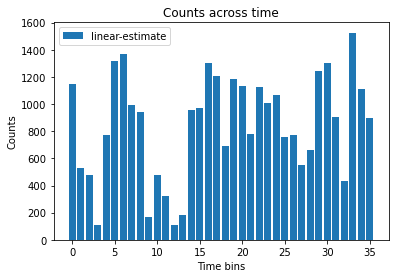

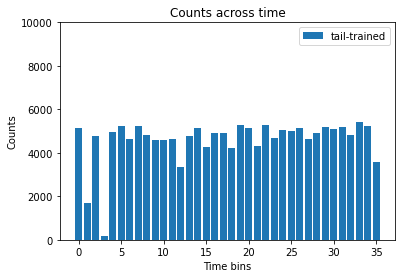

In [147]:
def extract_time(filename, starttime, endtime, **kwargs):
    '''
    Creates time bins of data and finds net counts of each time bin
    
        Parameters:
            filename: data file in csv form
            starttime (int): starting unix timestamp
            endtime (int): ending unix timestamp
            Keyword arguments:
            plot_all (boolean): option to generate visual plots for each individual time bin
        Returns:
        tail_counts (int): net counts calculated by left-tail training
        straight_counts(int): net counts calculated by linear estimation
    '''
    
    
    df = pd.read_csv(filename)
    df = df.fillna(method = 'ffill') # forward-filling all the NaNs
    timevals = df['deviceTime_unix'].to_list() # finding time data
    df = df.set_index('deviceTime_unix')
    lst = [[]]
    start = timevals[0]
    for val in timevals:
        if val-start < 30000:
                lst[-1].append(val)
        else:
            lst.append([val])
            start = val
    num_bins = len(lst)
    tail_counts = []
    straight_counts = []
    binrange = range(0, num_bins)
    for i in range (0, num_bins):
        binval1 = lst[i][0]
        last_binval = lst[i][-1] 
        print('from timestamp',binval1, 'to',last_binval)
        spectra = df.loc[binval1:last_binval, '0':'1023'] # slicing specific time interval of spectra
        array = spectra.to_numpy()
        spectrum = array.sum(axis = 0)
        x_all = np.array(range(0, 1024))
        tail, straight = NetCounts_subtraction(x_all, spectrum, 560, 590, **params)
        tail_counts.append(tail)
        straight_counts.append(straight)
    plt.bar(binrange, straight_counts, label='linear-estimate')
    plt.title('Counts across time')
    plt.xlabel('Time bins')
    plt.ylabel('Counts')
    plt.legend()
    plt.show()
    plt.bar(binrange, tail_counts, label='tail-trained')
    plt.title('Counts across time')
    plt.xlabel('Time bins')
    plt.ylabel('Counts')
    plt.legend()
    plt.show()
    return(tail_counts, straight_counts)
    
params = {'p0':[1000, 0.05], 'offset':None, 'tail length':0.46, 'plot_all':False}

extract_time('/home/akhila/Downloads/etch_roof_CesiumIodide.csv', 1490046365,1491791174)
x,y=setup('/home/akhila/Downloads/etch_roof_CesiumIodide.csv')